In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import  numpy as np

In [4]:
df_transaction = pd.read_csv('transactions_dataset.csv', sep=';')

In [5]:
df_transaction

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051
...,...,...,...,...,...,...,...,...
63319310,2019-06-10,2020-06-12,1596284,245272,-2056.91300,5,by phone,7682
63319311,2018-12-14,2020-07-15,908253,880496,27.62760,1001,by phone,9375
63319312,2019-07-26,2020-10-29,1168247,2063314,-204.60984,101,by phone,3014
63319313,2018-05-23,2020-11-27,2319965,1287654,70.49730,17,by phone,1015


In [6]:
df_transaction.date_order = pd.to_datetime(df_transaction.date_order)
df_transaction.date_invoice = pd.to_datetime(df_transaction.date_invoice)

In [7]:
df_transaction.date_order.min()

Timestamp('2017-09-22 00:00:00')

In [8]:
df_transaction.date_order.max()

Timestamp('2019-09-22 00:00:00')

In [9]:
df_transaction['df_delta_time'] = (df_transaction.date_invoice - df_transaction.date_order).dt.days

In [10]:
df_transaction_agg = (df_transaction.assign(month = df_transaction.date_order.dt.month,
                       year = df_transaction.date_order.dt.year,
                       day = df_transaction.date_order.dt.day)
               .groupby(by=['year','month','day','client_id'])
               .agg({'sales_net': ['count', 'mean', 'sum'],
#                     'date_order': lambda x : x
                     })
)

In [11]:
df_transaction_agg

sales_net                         
                             count        mean          sum
year month day client_id                                   
2017 9     22  403403            3  221.747600   665.242800
               585799            4  163.654200   654.616800
               591886            2    0.000000     0.000000
               688261            7  349.081183  2443.568280
               791423            3  110.344800   331.034400
...                            ...         ...          ...
2019 9     22  2039787           1  151.982160   151.982160
               2058530           3  467.707190  1403.121571
               2076261           1  166.037000   166.037000
               2153179           6  236.545800  1419.274800
               2265063          16  141.587559  2265.400947

[7955289 rows x 3 columns]

In [12]:
df_transaction_agg['date'] = pd.to_datetime(
    df_transaction_agg.index.get_level_values(0).astype(str) 
    + '-'
    + df_transaction_agg.index.get_level_values(1).astype(str) 
    + '-'
    + df_transaction_agg.index.get_level_values(2).astype(str)
)


In [13]:
df_transaction_agg = df_transaction_agg.droplevel([0,1,2])

In [14]:
df_transaction_agg.index.value_counts()

client_id
1162413    576
705312     568
1444500    560
1890528    558
1061219    553
          ... 
2222254      1
2213723      1
2135388      1
2042147      1
1630903      1
Name: count, Length: 170589, dtype: int64

array([[<AxesSubplot:title={'center':'client_id'}>]], dtype=object)

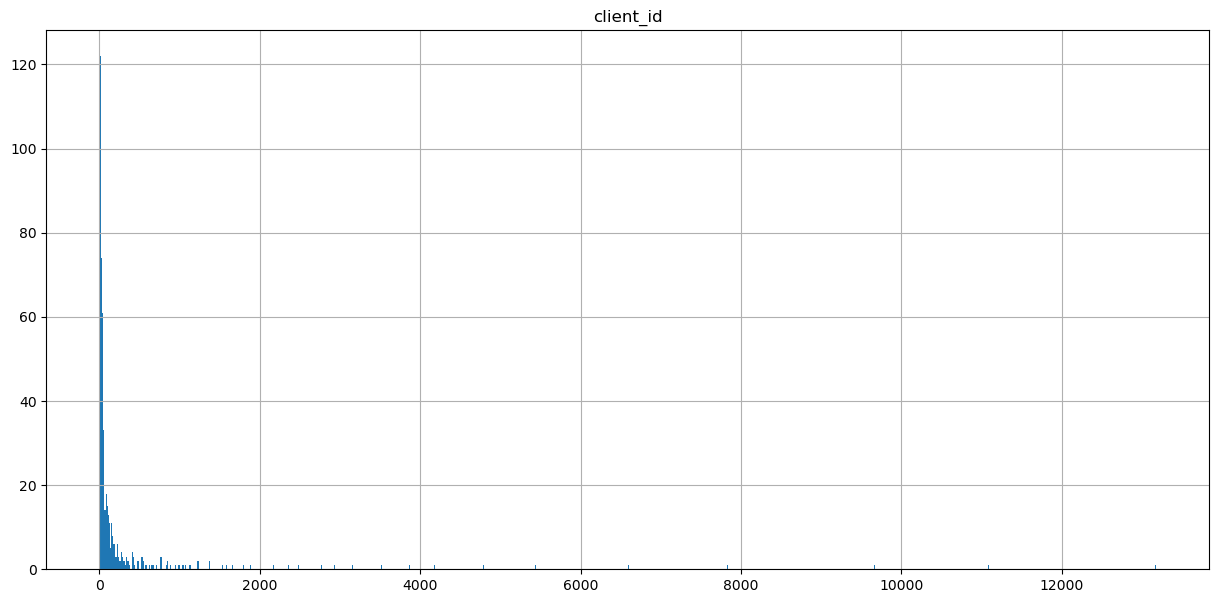

In [15]:
pd.DataFrame(df_transaction_agg.index.value_counts()[:-10000]).assign( client_id = lambda x : x.index ).groupby(by='count').count().hist(bins=1000, figsize=(15,7))

In [16]:
df_transaction_agg.index.value_counts()[df_transaction_agg.index.value_counts().gt(1)].sum()

7934208

In [17]:
df_transaction_agg.index.value_counts()[~df_transaction_agg.index.value_counts().gt(1)].sum()

21081

In [18]:
df_date = pd.DataFrame(df_transaction_agg['date']).groupby(by='client_id').date.apply(list)
df_date_expanded = pd.DataFrame(df_date.values.tolist(), index=df_date.index)

In [19]:
(df_date_expanded[0] - df_date_expanded[1]).dt.days

client_id
6          -33.0
7         -161.0
14          -1.0
18          -1.0
25           NaN
           ...  
2274456     -1.0
2274479   -485.0
2274504   -425.0
2274508      NaN
2274517    -30.0
Length: 170589, dtype: float64

In [20]:
df_delta = df_date_expanded.copy()
for i in range(575):
    df_delta[i] = -(df_delta[i] - df_delta[i+1]).dt.days

In [21]:
df_delta.drop(columns=[575], inplace=True)

In [22]:
df_delta.to_numpy().flatten()

array([ 33., 121.,  41., ...,  nan,  nan,  nan])

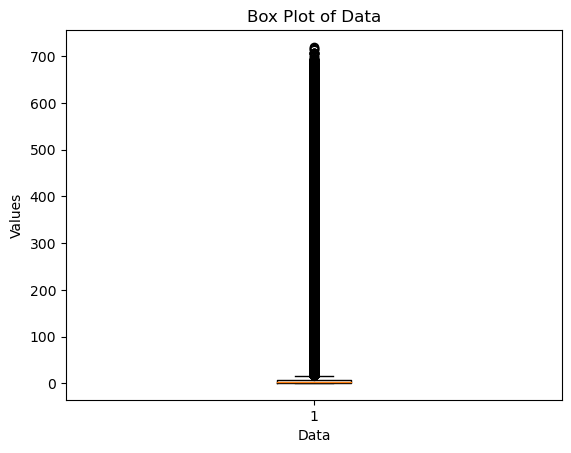

In [25]:
import matplotlib.pyplot as plt

# Assuming df_delta is your DataFrame
data = df_delta.to_numpy().flatten()
data_without_nan = data[~np.isnan(data)]

plt.boxplot(data_without_nan)
plt.title('Box Plot of Data')
plt.xlabel('Data')
plt.ylabel('Values')
plt.show()


<AxesSubplot:>

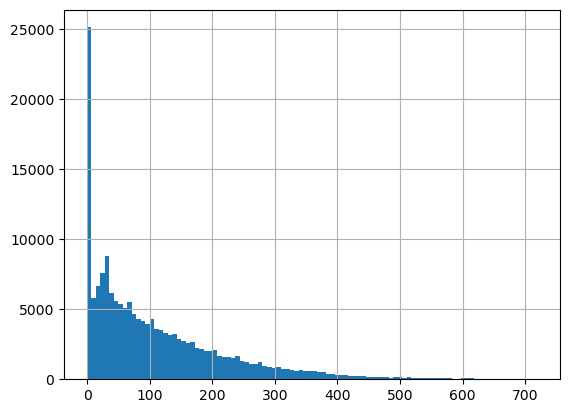

In [26]:
df_delta.fillna(-1).max(axis=1).hist(bins=100)

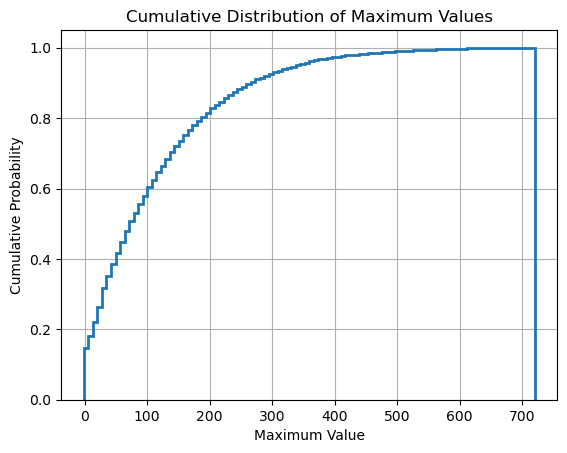

In [27]:
import matplotlib.pyplot as plt

# Assuming df_delta is your DataFrame
df_delta.fillna(-1).max(axis=1).hist(bins=100, cumulative=True, density=True, histtype='step', linewidth=2)
plt.title('Cumulative Distribution of Maximum Values')
plt.xlabel('Maximum Value')
plt.ylabel('Cumulative Probability')
plt.show()


In [28]:
import matplotlib.pyplot as plt

# Assuming df_delta is your DataFrame
df_delta.fillna(-1).to_numpy().flatten().hist(bins=100, cumulative=True, density=True, histtype='step', linewidth=2)
plt.title('Cumulative Distribution of Maximum Values')
plt.xlabel('Maximum Value')
plt.ylabel('Cumulative Probability')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'hist'

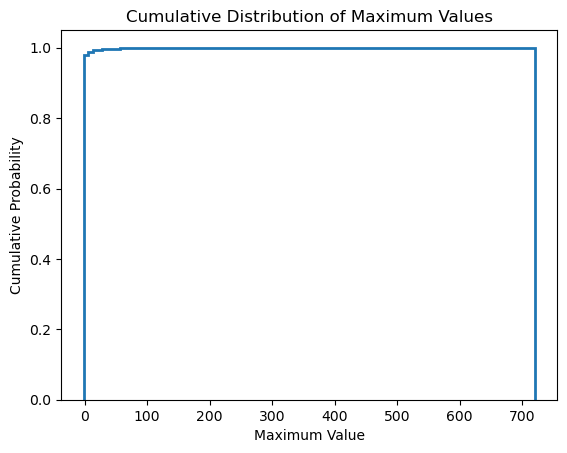

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_delta is your DataFrame
data = df_delta.fillna(-1).to_numpy().flatten()

plt.hist(data, bins=100, cumulative=True, density=True, histtype='step', linewidth=2)
plt.title('Cumulative Distribution of Maximum Values')
plt.xlabel('Maximum Value')
plt.ylabel('Cumulative Probability')
plt.show()


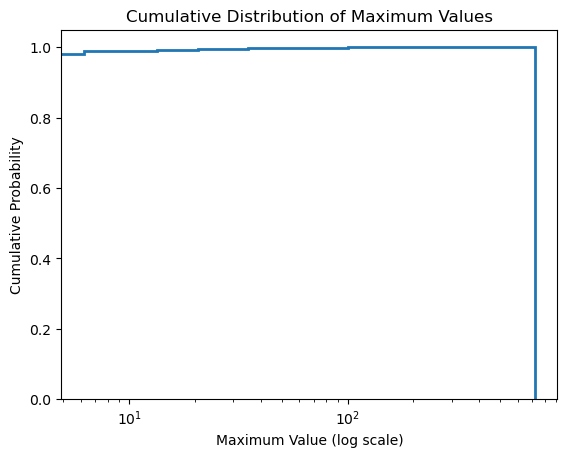

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_delta is your DataFrame
data = df_delta.fillna(-1).to_numpy().flatten()

plt.hist(data, bins=100, cumulative=True, density=True, histtype='step', linewidth=2)
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title('Cumulative Distribution of Maximum Values')
plt.xlabel('Maximum Value (log scale)')
plt.ylabel('Cumulative Probability')
plt.show()


# Churn curve plot

In [31]:
df_transaction = pd.read_csv('transactions_dataset.csv', sep=';')

df_transaction.date_order = pd.to_datetime(df_transaction.date_order)
df_transaction.date_invoice = pd.to_datetime(df_transaction.date_invoice)

df_transaction['df_delta_time'] = (df_transaction.date_invoice - df_transaction.date_order).dt.days

In [32]:
df_transaction_agg = (df_transaction.assign(month = df_transaction.date_order.dt.month,
                       year = df_transaction.date_order.dt.year,
                       day = df_transaction.date_order.dt.day)
               .groupby(by=['year','month','day','client_id'])
               .agg({'sales_net': ['count', 'mean', 'sum'],
                     })
)

df_transaction_agg['date'] = pd.to_datetime(
    df_transaction_agg.index.get_level_values(0).astype(str) 
    + '-'
    + df_transaction_agg.index.get_level_values(1).astype(str) 
    + '-'
    + df_transaction_agg.index.get_level_values(2).astype(str)
)

df_transaction_agg = df_transaction_agg.droplevel([0,1,2])

df_date = pd.DataFrame(df_transaction_agg['date']).groupby(by='client_id').date.apply(list)
df_date_expanded = pd.DataFrame(df_date.values.tolist(), index=df_date.index)

df_delta = df_date_expanded.copy()
for i in range(575):
    df_delta[i] = -(df_delta[i] - df_delta[i+1]).dt.days

df_delta.drop(columns=[575], inplace=True)

#df_delta.to_numpy().flatten()

In [35]:
flat = df_delta.fillna(-1).to_numpy().flatten()

array([ 33., 121.,  41., ...,  -1.,  -1.,  -1.])

In [36]:
def get_frequence(days_array, J=30):
    freq_list = []
    pop_list = []
    for i in range(int(max(days_array))):
        freq_list.append(np.mean((days_array[days_array > i] - i) < J))
        pop_list.append(days_array[days_array > i])
    return (np.array(freq_list), np.array(pop_list))

In [38]:
import numpy as np

def value_counts_np(array):
    unique_values, counts = np.unique(array, return_counts=True)
    result = dict(zip(unique_values, counts))
    return result

# Example usage:
data = df_delta.fillna(-1).to_numpy()[:,-1]
counts = value_counts_np(data)
print(counts)


{-1.0: 170588, 1.0: 1}


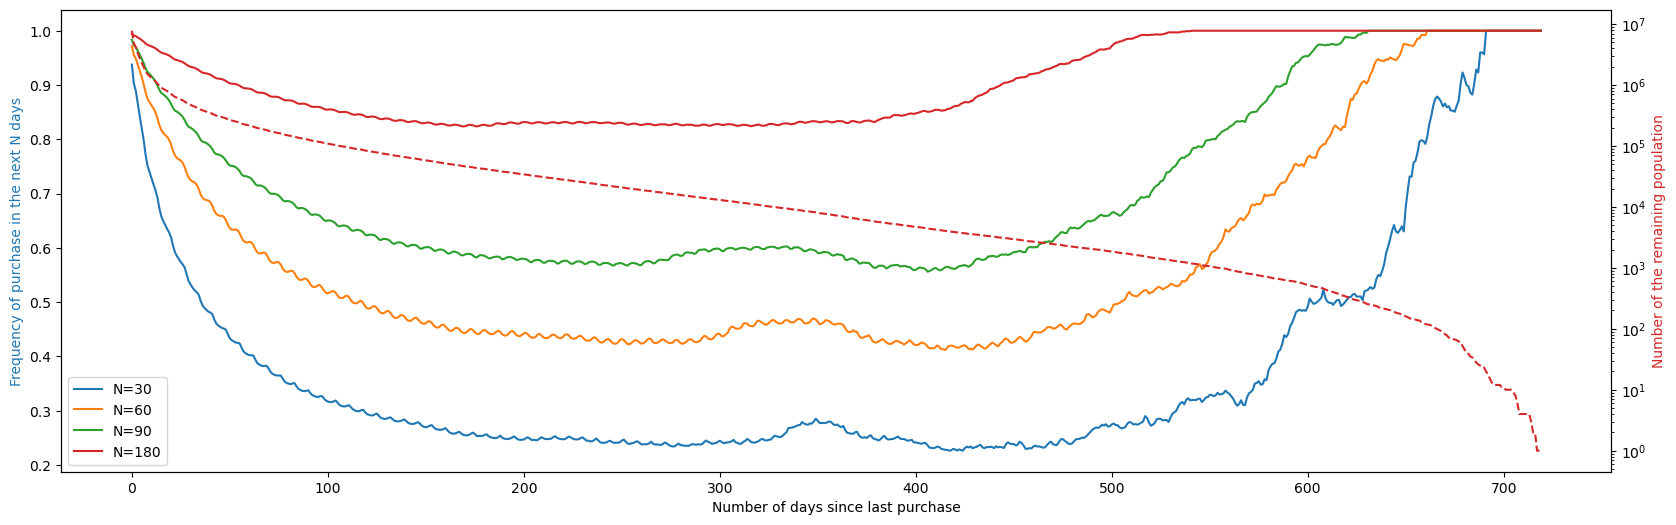

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_frequence(days_array, J=30):
    freq_list = []
    pop_list = []
    for i in range(int(max(days_array))):
        freq_list.append(np.mean((days_array[days_array > i] - i) < J))
        pop_list.append(np.sum((days_array > i)))
    return np.array(freq_list), np.array(pop_list)

fig, ax1 = plt.subplots(figsize=(20, 6))

N_list = [30, 60, 90, 180]
for N in N_list:
    freq_list, pop_list = get_frequence(flat, J=N)
    ax1.plot(freq_list, label=f'N={N}')

ax1.set_xlabel('Number of days since last purchase')
ax1.set_ylabel('Frequency of purchase in the next N days', color='tab:blue')
ax1.legend(loc='lower left')

ax2 = ax1.twinx()  # instantiate a second y-axis that shares the same x-axis
ax2.plot(pop_list, color='tab:red', linestyle='dashed')
ax2.set_ylabel('Number of the remaining population', color='tab:red')
ax2.set_yscale('log')  # Set y-axis to logarithmic scale

plt.show()


# Test feature function

In [ ]:
from preprocessing import create_features

In [44]:
df_transaction.date_order.max()

Timestamp('2019-09-22 00:00:00')

In [46]:
df = create_features(df_transaction, pd.to_datetime('2019-05-22'))

In [47]:
df

,client_id,avg_nb_distinct_prod_per_order,nb_orders,time_delta,avg_freq_orders,total_sales_net,avg_basket,pct_at_the_store,pct_by_phone,pct_during_the_visit_of_a_sales_rep,pct_online,pct_other,time_since_last_order,std_order_freq
0,6,2.700000,10,474,0.021097,3.492387e+03,349.238713,0.500000,0.500000,0.0,0.000000,0.0,98,181.0
1,7,7.500000,2,161,0.012422,1.190777e+03,595.388542,1.000000,0.000000,0.0,0.000000,0.0,149,113.0
2,14,22.466667,420,604,0.695364,2.593947e+06,6176.065387,0.085714,0.704762,0.0,0.209524,0.0,0,175.0
3,18,6.487288,236,603,0.391376,1.873674e+05,793.929486,0.656780,0.343220,0.0,0.000000,0.0,0,171.0
4,25,4.000000,1,0,0.000000,3.745861e+02,374.586096,1.000000,0.000000,0.0,0.000000,0.0,224,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161739,2274440,4.600000,20,599,0.033389,1.909148e+04,954.574212,0.700000,0.300000,0.0,0.000000,0.0,2,212.0
161740,2274479,2.500000,2,485,0.004124,4.959214e+02,247.960700,1.000000,0.000000,0.0,0.000000,0.0,84,342.0
161741,2274504,2.000000,2,425,0.004706,1.132566e+02,56.628300,0.500000,0.500000,0.0,0.000000,0.0,141,300.0
161742,2274508,4.000000,1,0,0.000000,7.270190e+01,72.701896,1.000000,0.000000,0.0,0.000000,0.0,581,NaN
